In [2]:
import requests
import lxml.html as lh
import numpy as np
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

#print(page.text)

In [21]:
URL = 'https://www.itsrugby.co.uk/archives-irluk.html'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
for a_href in soup.find_all('a', href=True):
    #if (str(a_href['href'])[0:7] == 'result-'):
    url_tails.append(str(a_href['href'])[6:])
    print(a_href['href'])

/index.php
https://twitter.com/itsrugby_uk
http://www.itsrugby.fr
//www.itsrugby.co.uk
http://www.itsrugby.es
/index.html
/results.html
/competitions.html
/playersearch.html
/index.html
/results.html
/playersearch.html
/archives.html
/result-englandpremiership.html
/result-unitedrugbychampionship.html
/result-englandchampionship.html
/result-englandd3.html
/result-premiershuprugbycup.html
/result-ercchampionscup.html
/result-ercchallengecup.html
/result-europesupercup.html
/result-nrl.html
/result-superleague.html
/result-rugbyleaguechampionship.html
/result-rugbyleagueleagueone.html
/result-englishcup13.html
/result-stateoforigin.html
/result-elitefrancexiii.html
/result-superrugby.html
/result-curriecup.html
/result-curriecupfirstdiv.html
/result-npc.html
/result-urbatop13.html
/result-nswshuteshield.html
/result-superligaamericana.html
/result-worldcup.html
/result-nations6.html
/result-rugbychampionship.html
/result-tests.html
/result-rugbyeuropechampionship.html
/result-rugbyeurop

In [41]:
#Function only returns data for the top league from region (As decided by itsrugby.com)

### Make inside for loup a function
def league_stats(region_key):
    URL = 'https://www.itsrugby.co.uk/' + region_key + '.html'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    url_tails = []
    url_head = 'https://www.itsrugby.co.uk/'
    league_stats = {'tries_avg': [], 'tries_nb': [], 'conv_avg': [], 'conv_nb': [], 'pen_avg': [], 'pen_nb': [], 'dg_avg': [], 'dg_nb': [], 'year': []}
    result_ind = [1,0,7,6,13,12,19,18]
    for a_href in soup.find_all('a', href=True):
        if (str(a_href['href'])[0:7] == 'result-'):
            url_tails.append(str(a_href['href'])[6:])
    #print(url_tails)
    for i in range(len(url_tails)):
        URL = url_head + 'stats' + url_tails[i]
        #print(URL)
        page = requests.get(URL)
        soup = BeautifulSoup(page.text, "html.parser")
        result_array = []
        year = URL[-9:-5]
        count = 0
        for result in soup.find_all('tr'):
            for result2 in result.find_all('td', attrs = {"align": "center", "id": "noir"}):
                #print(len(list(result2.contents)))
                if (count>7 and count <32):
                        #print(result2.contents)
                    try:
                        result_array.append(float(result2.contents[0]))
                    except: 
                        result_array.append(np.nan)
                count+=1
        #print(result_array)
        for k in range(8):
            try:
                league_stats[list(league_stats.keys())[k]].append(result_array[result_ind[k]])
            except IndexError: 
                league_stats[list(league_stats.keys())[k]].append(np.nan)
    
        league_stats['year'].append(year)
    return(league_stats)

In [66]:
ml_stats = {}
ml_leagues = ['englandpremiership', 'top14', 'superrugby', '6nationstournament', 'heinekencup']
archive_links = ['archives-irluk', 'archives-fr', 'archives-hemsud', 'archives-int', 'archives-cupeurope']
for i in range(len(ml_leagues)):
    ml_stats[ml_leagues[i]] = league_stats(archive_links[i])
    print(ml_stats[ml_leagues[i]])
for key, value in ml_stats['superrugby'].items():
    print(value[1])
    value[1] = np.nan
ml_stats['superrugby']['year'][1] = '2019'
#Error with 2019-2020 super rugby data. does not match other leagues

{'tries_avg': [6.65, 5.71, 5.63, 5.59, 5.85, 5.5, 4.64, 5.25, 4.27, 3.98, 3.69, 3.81, 3.23, 4.12, 4.56, 4.05, 4.05, 3.87, 4.37, nan], 'tries_nb': [1038.0, 755.0, 744.0, 738.0, 773.0, 726.0, 613.0, 693.0, 564.0, 526.0, 488.0, 503.0, 427.0, 544.0, 603.0, 535.0, 535.0, 512.0, 577.0, nan], 'conv_avg': [4.82, 4.24, 4.13, 4.27, 4.25, 4.11, 3.25, 3.75, 2.93, 2.79, 2.59, 2.87, 2.25, 2.72, 2.98, 2.66, 2.79, 2.71, 3.16, nan], 'conv_nb': [752.0, 560.0, 546.0, 564.0, 562.0, 543.0, 430.0, 496.0, 388.0, 369.0, 343.0, 379.0, 297.0, 360.0, 394.0, 352.0, 369.0, 358.0, 418.0, nan], 'pen_avg': [2.55, 2.78, 3.18, 3.69, 3.4, 3.87, 4.35, 4.67, 4.59, 6.09, 5.69, 5.45, 5.28, 4.68, 4.21, 4.84, 5.11, 4.75, 4.94, nan], 'pen_nb': [399.0, 367.0, 420.0, 488.0, 450.0, 512.0, 575.0, 617.0, 607.0, 805.0, 752.0, 720.0, 697.0, 619.0, 556.0, 640.0, 675.0, 627.0, 653.0, nan], 'dg_avg': [0.03, 0.02, 0.03, 0.01, 0.05, 0.06, 0.03, 0.06, 0.09, 0.09, 0.18, 0.17, 0.31, 0.24, 0.3, 0.27, 0.29, 0.49, 0.24, nan], 'dg_nb': [6.0, 3.0

In [68]:
print(ml_stats['superrugby'])


{'tries_avg': [8.68, nan, 6.5, 7.31, 6.97, 6.43, 5.08, 4.89, 4.83, 4.92, 5.8, 5.47, 5.3, 4.68, 4.75, 5.77, 6.65, 6.51], 'tries_nb': [217.0, nan, 781.0, 878.0, 942.0, 869.0, 610.0, 587.0, 580.0, 591.0, 528.0, 498.0, 483.0, 426.0, 433.0, 381.0, 439.0, 430.0], 'conv_avg': [6.6, nan, 4.8, 5.57, 5.08, 4.6, 3.69, 3.71, 3.48, 3.73, 4.24, 3.94, 3.68, 3.27, 3.47, 4.1, 4.87, 4.66], 'conv_nb': [165.0, nan, 577.0, 669.0, 686.0, 622.0, 443.0, 446.0, 418.0, 448.0, 386.0, 359.0, 335.0, 298.0, 316.0, 271.0, 322.0, 308.0], 'pen_avg': [1.15, nan, 2.61, 2.62, 3.17, 3.54, 4.09, 5.3, 5.32, 5.53, 4.93, 2.73, 3.14, 4.48, 4.2, 3.65, 4.0, 4.39], 'pen_nb': [29.0, nan, 314.0, 315.0, 429.0, 478.0, 491.0, 637.0, 639.0, 664.0, 449.0, 249.0, 286.0, 408.0, 383.0, 241.0, 264.0, 290.0], 'dg_avg': [0.0, nan, 0.03, 0.0, 0.02, 0.05, 0.08, 0.17, 0.06, 0.1, 0.18, 0.3, 0.2, 0.18, 0.13, 0.15, 0.07, 0.24], 'dg_nb': [0.0, nan, 4.0, 1.0, 3.0, 8.0, 10.0, 21.0, 8.0, 12.0, 17.0, 28.0, 19.0, 17.0, 12.0, 10.0, 5.0, 16.0], 'year': ['2

In [ ]:
X = []
y = []
for key, value in msl

dict_keys(['englandpremiership', 'top14', 'superrugby', '6nationstournament', 'heinekencup'])
dict_keys(['englandpremiership', 'top14', 'superrugby', '6nationstournament', 'heinekencup'])


(2010.0, 2021.0)

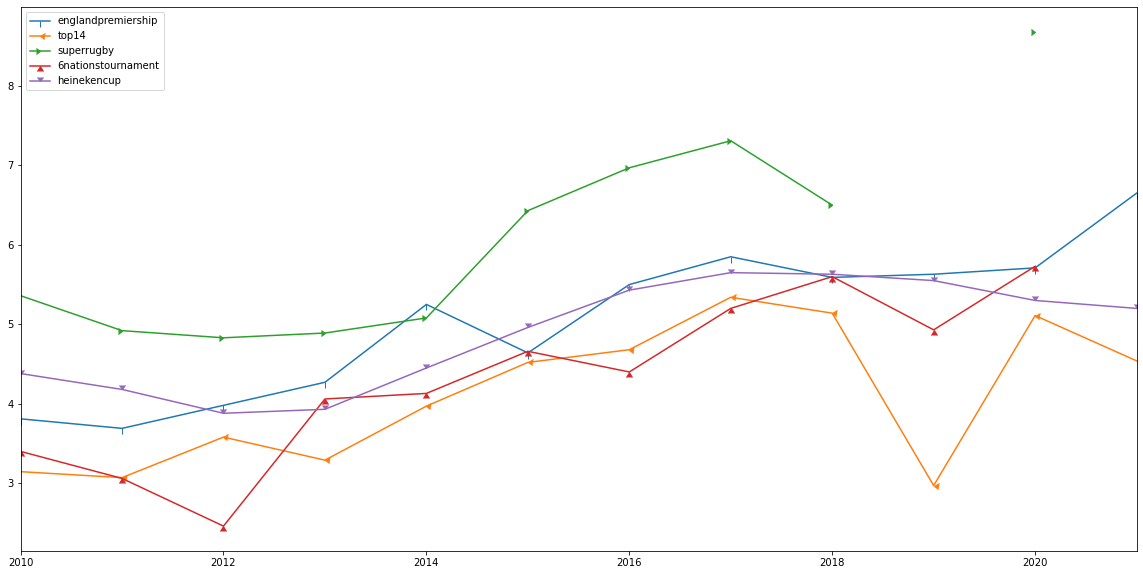

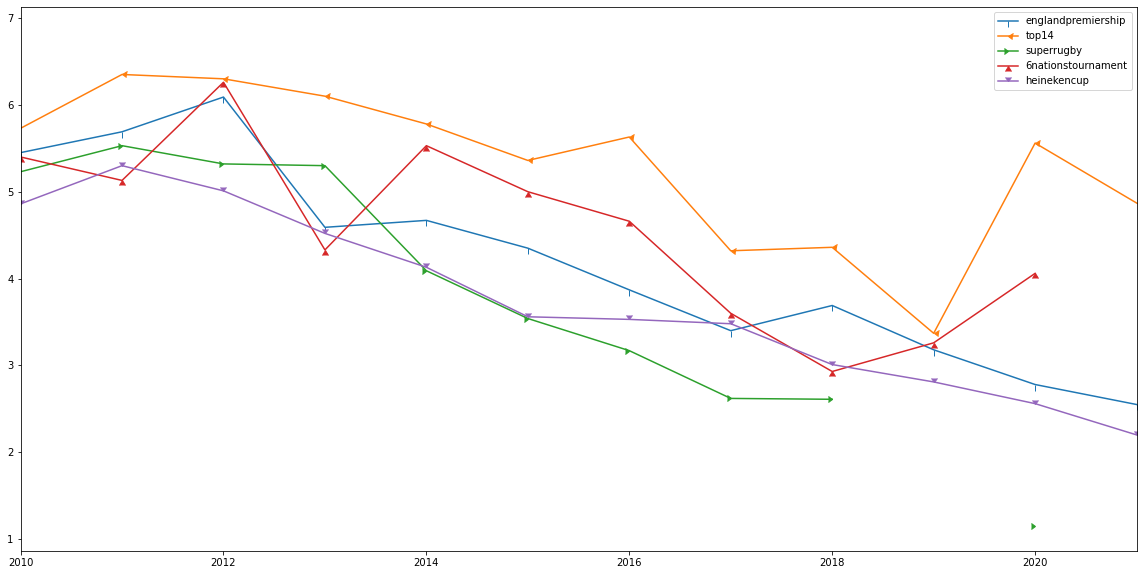

In [71]:
print(ml_stats.keys())
plt.figure(figsize=(20,10))
count = 2
for key, value in ml_stats.items():
    #plt.xlim([1995, 2021])
    count += 1
    plt.plot(np.flip(np.array(value['year']).astype('float64')), np.flip(np.array(value['tries_avg'])), marker = count)
    #print(np.flip(np.array(value['year'])))
plt.legend(list(ml_stats.keys()))
plt.xlim([2010, 2021])
print(ml_stats.keys())
plt.figure(figsize=(20,10))
count = 2
for key, value in ml_stats.items():
    #plt.xlim([1995, 2021])
    count += 1
    plt.plot(np.flip(np.array(value['year']).astype('float64')), np.flip(np.array(value['pen_avg'])), marker = count)
    #print(np.flip(np.array(value['year'])))
plt.legend(list(ml_stats.keys()))
plt.xlim([2010, 2021])


In [31]:
URL = 'https://www.itsrugby.co.uk/archives-irluk.html'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
url_tails = []
url_head = 'https://www.itsrugby.co.uk/'
big4_stats = {}
league_stats = {}
big4_leagues = ['englandpremiership', 'top14', 'superrugby', '6nationstournament', 'heinekencup', 'topleague']
archive_links = ['archives-irluk', 'archives-fr', 'archives-hemsud', 'archives-int', 'archives-cupeurope', 'archives-jap']
league_stats = {'tries_avg': [], 'tries_nb': [], 'conv_avg': [], 'conv_nb': [], 'pen_avg': [], 'pen_nb': [], 'dg_avg': [], 'dg_nb': [], 'year': []}

result_ind = [1,0,7,6,13,12,19,18]
result_stat = ['tries_avg', 'tries_nb', 'conv_avg', 'conv_nb', 'pen_avg', 'pen_nb', 'dg_avg', 'dg_nb', 'year']
for a_href in soup.find_all('a', href=True):
    if (str(a_href['href'])[0:7] == 'result-'):
        url_tails.append(str(a_href['href'])[6:])
        #print(a_href['href'])
print(url_tails)
#year = []
for i in range(len(url_tails)):
    URL = url_head + 'stats' + url_tails[i]
    print(URL)
    page = requests.get(URL)
    soup = BeautifulSoup(page.text, "html.parser")
    result_array = []
    year = URL[-9:-5]
    count = 0
    for result in soup.find_all('tr'):
            #print(len(list(result)))
        for result2 in result.find_all('td', attrs = {"align": "center", "id": "noir"}):
                #print(len(list(result2.contents)))
            if (count>7 and count <32):
                    #print(result2.contents)
                try:
                    result_array.append(float(result2.contents[0]))
                except: 
                    result_array.append(np.nan)
            count+=1
    print(result_array)
    for k in range(8):
        try:
            league_stats[result_stat[k]].append(result_array[result_ind[k]])
        except IndexError: 
            league_stats[result_stat[k]].append(np.nan)
    
    league_stats['year'].append(year)
    

['-englandpremiership-2021.html', '-englandpremiership-2020.html', '-englandpremiership-2019.html', '-premiershiprugby-2018.html', '-avivapremiership-2017.html', '-avivapremiership-2016.html', '-avivapremiership-2015.html', '-avivapremiership-2014.html', '-avivapremiership-2013.html', '-avivapremiership-2012.html', '-avivapremiership-2011.html', '-avivapremiership-2010.html', '-guinesspremiership-2009.html', '-guinesspremiership-2008.html', '-guinesspremiership-2007.html', '-guinesspremiership-2006.html', '-guinesspremiership-2005.html', '-zurichchampionship-2004.html', '-zurichchampionship-2003.html', '-CHAMP_2_1-2002.html']
https://www.itsrugby.co.uk/stats-englandpremiership-2021.html
[1038.0, 6.65, 561.0, 3.59, 477.0, 3.05, 752.0, 4.82, 418.0, 2.67, 334.0, 2.14, 399.0, 2.55, 206.0, 1.32, 193.0, 1.23, 6.0, 0.03, 2.0, 0.01, 4.0, 0.02]
https://www.itsrugby.co.uk/stats-englandpremiership-2020.html
[755.0, 5.71, 405.0, 3.06, 350.0, 2.65, 560.0, 4.24, 309.0, 2.34, 251.0, 1.9, 367.0, 2.78,

In [32]:
print(league_stats)

{'tries_avg': [6.65, 5.71, 5.63, 5.59, 5.85, 5.5, 4.64, 5.25, 4.27, 3.98, 3.69, 3.81, 3.23, 4.12, 4.56, 4.05, 4.05, 3.87, 4.37, nan], 'tries_nb': [1038.0, 755.0, 744.0, 738.0, 773.0, 726.0, 613.0, 693.0, 564.0, 526.0, 488.0, 503.0, 427.0, 544.0, 603.0, 535.0, 535.0, 512.0, 577.0, nan], 'conv_avg': [4.82, 4.24, 4.13, 4.27, 4.25, 4.11, 3.25, 3.75, 2.93, 2.79, 2.59, 2.87, 2.25, 2.72, 2.98, 2.66, 2.79, 2.71, 3.16, nan], 'conv_nb': [752.0, 560.0, 546.0, 564.0, 562.0, 543.0, 430.0, 496.0, 388.0, 369.0, 343.0, 379.0, 297.0, 360.0, 394.0, 352.0, 369.0, 358.0, 418.0, nan], 'pen_avg': [2.55, 2.78, 3.18, 3.69, 3.4, 3.87, 4.35, 4.67, 4.59, 6.09, 5.69, 5.45, 5.28, 4.68, 4.21, 4.84, 5.11, 4.75, 4.94, nan], 'pen_nb': [399.0, 367.0, 420.0, 488.0, 450.0, 512.0, 575.0, 617.0, 607.0, 805.0, 752.0, 720.0, 697.0, 619.0, 556.0, 640.0, 675.0, 627.0, 653.0, nan], 'dg_avg': [0.03, 0.02, 0.03, 0.01, 0.05, 0.06, 0.03, 0.06, 0.09, 0.09, 0.18, 0.17, 0.31, 0.24, 0.3, 0.27, 0.29, 0.49, 0.24, nan], 'dg_nb': [6.0, 3.0

In [165]:
#Generate league name csv
leagues = ['top14', 'prod2', 'federale1', 'englandpremiership', 'pro14', 'englishchampionship', 'superrugby', 'itmcup', 'curriecup', 'urbatop14']
league_name_arr = np.zeros((len(leagues), 10)).astype(str)

for i in range(len(leagues)):
    league_name_arr[i,:] = leagues[i]  

In [166]:
leagues = ['top14', 'prod2', 'federale1', 'englandpremiership', 'pro14', 'englishchampionship', 'superrugby', 'itmcup', 'curriecup', 'urbatop14']
years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
for i in range(len(leagues)):
    league_stats = {'tries_avg': [], 'tries_nb': [], 'conv_avg': [], 'conv_nb': [], 'pen_avg': [], 'pen_nb': [], 'dg_avg': [], 'dg_nb': []}
    for j in range(len(years)):
        URL = 'https://www.itsrugby.co.uk/stats-{league}-{year}.html'.format(league = leagues[i], year = years[j])
        #rint(URL)
        page = requests.get(URL)
        soup = BeautifulSoup(page.text, "html.parser")
        result_array = []
        count = 0
        if(len(list(soup.find_all('tr'))) <50 ):
            league_name_arr[i,j] = 'error'

    


In [167]:
x_error = []
y_error = []
count = 0
for i in range(league_name_arr.shape[0]):
    for j in range(league_name_arr.shape[1]):
        if(league_name_arr[i,j] == 'error'):
            print(leagues[i], years[j])
            print(i,j)
            x_error.append(i)
            y_error.append(j)
            count += 1
            print(count)

federale1 2013
2 2
1
englandpremiership 2011
3 0
2
englandpremiership 2012
3 1
3
englandpremiership 2013
3 2
4
englandpremiership 2014
3 3
5
englandpremiership 2015
3 4
6
englandpremiership 2016
3 5
7
englandpremiership 2017
3 6
8
englandpremiership 2018
3 7
9
pro14 2011
4 0
10
pro14 2012
4 1
11
pro14 2013
4 2
12
pro14 2014
4 3
13
pro14 2015
4 4
14
pro14 2016
4 5
15
pro14 2017
4 6
16
pro14 2018
4 7
17
englishchampionship 2016
5 5
18
englishchampionship 2017
5 6
19
englishchampionship 2018
5 7
20
englishchampionship 2019
5 8
21
englishchampionship 2020
5 9
22
itmcup 2019
7 8
23
itmcup 2020
7 9
24
urbatop14 2016
9 5
25
urbatop14 2017
9 6
26
urbatop14 2018
9 7
27
urbatop14 2019
9 8
28
urbatop14 2020
9 9
29


In [168]:
print(x_error)

[2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 7, 7, 9, 9, 9, 9, 9]


In [179]:
error_fixes = ['federale1', 'avivapremiership', 'avivapremiership', 'avivapremiership', 'avivapremiership', 'avivapremiership','avivapremiership', 'avivapremiership', 'premiershiprugby', 'rabodirect12', 'rabodirect12', 'rabodirect12', 'guinesspro12', 'guinesspro12', 'pro12rugby', 'guinesspro14', 'guinesspro14', 'angleterred21', 'angleterred21', 'englandchampionship', 'englandd1', 'englandd1', 'mitre10cup', 'mitre10cup', 'urbatop12', 'urbatop12', 'urbatop12', 'error', 'urbatop12']
for i in range(len(error_fixes)):
    league_name_arr[x_error[i], y_error[i]] = error_fixes[i]


In [170]:
print(league_name_arr[:,:])

[['top14' 'top14' 'top14' 'top14' 'top14' 'top14' 'top14' 'top14' 'top14'
  'top14']
 ['prod2' 'prod2' 'prod2' 'prod2' 'prod2' 'prod2' 'prod2' 'prod2' 'prod2'
  'prod2']
 ['federale1' 'federale1' 'federale1' 'federale1' 'federale1' 'federale1'
  'federale1' 'federale1' 'federale1' 'federale1']
 ['avivapremiership' 'avivapremiership' 'avivapremiership'
  'avivapremiership' 'avivapremiership' 'avivapremiership'
  'avivapremiership' 'premiershiprugby' 'englandpremiership'
  'englandpremiership']
 ['rabodirect12' 'rabodirect12' 'rabodirect12' 'guinesspro12'
  'guinesspro12' 'pro12rugby' 'guinesspro14' 'guinesspro14' 'pro14'
  'pro14']
 ['englishchampionship' 'englishchampionship' 'englishchampionship'
  'englishchampionship' 'englishchampionship' 'angleterred21'
  'angleterred21' 'englandchampionship' 'englandd1' 'englandd1']
 ['superrugby' 'superrugby' 'superrugby' 'superrugby' 'superrugby'
  'superrugby' 'superrugby' 'superrugby' 'superrugby' 'superrugby']
 ['itmcup' 'itmcup' 'itmcup' 'i

In [180]:
from bs4 import BeautifulSoup
leagues_10yr_stats = {}
years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
result_ind = [1,0,7,6,13,12,19,18]
result_stat = ['tries_avg', 'tries_nb', 'conv_avg', 'conv_nb', 'pen_avg', 'pen_nb', 'dg_avg', 'dg_nb']
for i in range(len(leagues)):
    league_stats = {'tries_avg': [], 'tries_nb': [], 'conv_avg': [], 'conv_nb': [], 'pen_avg': [], 'pen_nb': [], 'dg_avg': [], 'dg_nb': []}
    for j in range(len(years)):
        URL = 'https://www.itsrugby.co.uk/stats-{league}-{year}.html'.format(league = league_name_arr[i,j], year = years[j])
        #rint(URL)
        page = requests.get(URL)
        soup = BeautifulSoup(page.text, "html.parser")
        result_array = []
        count = 0
        for result in soup.find_all('tr'):
            #print(len(list(result)))
            for result2 in result.find_all('td', attrs = {"align": "center", "id": "noir"}):
                #print(len(list(result2.contents)))
                if (count>7 and count <32):
                    #print(result2.contents)
                    try:
                        result_array.append(float(result2.contents[0]))
                    except: 
                        result_array.append(np.nan)
                count+=1
        print(result_array)
        for k in range(8):
            try:
                league_stats[result_stat[k]].append(result_array[result_ind[k]])
            except IndexError: 
                league_stats[result_stat[k]].append(np.nan)
                print(URL)
    leagues_10yr_stats[leagues[i]] = league_stats

[559.0, 3.07, 352.0, 1.93, 207.0, 1.13, 449.0, 2.46, 283.0, 1.55, 166.0, 0.91, 1157.0, 6.35, 672.0, 3.69, 485.0, 2.66, 60.0, 0.32, 30.0, 0.16, 30.0, 0.16]
[653.0, 3.58, 417.0, 2.29, 236.0, 1.29, 518.0, 2.84, 341.0, 1.87, 177.0, 0.97, 1148.0, 6.3, 660.0, 3.62, 488.0, 2.68, 59.0, 0.32, 29.0, 0.15, 30.0, 0.16]
[600.0, 3.29, 417.0, 2.29, 183.0, 1.0, 455.0, 2.5, 318.0, 1.74, 137.0, 0.75, 1111.0, 6.1, 621.0, 3.41, 490.0, 2.69, 52.0, 0.28, 27.0, 0.14, 25.0, 0.13]
[724.0, 3.97, 479.0, 2.63, 245.0, 1.34, 540.0, 2.96, 352.0, 1.93, 188.0, 1.03, 1053.0, 5.78, 562.0, 3.08, 491.0, 2.69, 42.0, 0.23, 15.0, 0.08, 27.0, 0.14]
[824.0, 4.52, 517.0, 2.84, 307.0, 1.68, 617.0, 3.39, 384.0, 2.1, 233.0, 1.28, 976.0, 5.36, 526.0, 2.89, 450.0, 2.47, 19.0, 0.1, 9.0, 0.04, 10.0, 0.05]
[853.0, 4.68, 528.0, 2.9, 325.0, 1.78, 671.0, 3.68, 425.0, 2.33, 246.0, 1.35, 1026.0, 5.63, 571.0, 3.13, 455.0, 2.5, 24.0, 0.13, 17.0, 0.09, 7.0, 0.03]
[973.0, 5.34, 600.0, 3.29, 373.0, 2.04, 754.0, 4.14, 480.0, 2.63, 274.0, 1.5, 787

[779.0, 5.64, 441.0, 3.19, 338.0, 2.44, 540.0, 3.91, 310.0, 2.24, 230.0, 1.66, 516.0, 3.73, 249.0, 1.8, 267.0, 1.93, 4.0, 0.02, 2.0, 0.01, 2.0, 0.01]
[784.0, 5.93, 425.0, 3.21, 359.0, 2.71, 520.0, 3.93, 289.0, 2.18, 231.0, 1.75, 411.0, 3.11, 198.0, 1.5, 213.0, 1.61, 7.0, 0.05, 5.0, 0.03, 2.0, 0.01]
[819.0, 6.2, 432.0, 3.27, 387.0, 2.93, 573.0, 4.34, 313.0, 2.37, 260.0, 1.96, 372.0, 2.81, 193.0, 1.46, 179.0, 1.35, 11.0, 0.08, 5.0, 0.03, 6.0, 0.04]
[787.0, 6.39, 404.0, 3.28, 383.0, 3.11, 536.0, 4.35, 281.0, 2.28, 255.0, 2.07, 326.0, 2.65, 170.0, 1.38, 156.0, 1.26, 12.0, 0.09, 4.0, 0.03, 8.0, 0.06]
[931.0, 7.05, 493.0, 3.73, 438.0, 3.31, 675.0, 5.11, 368.0, 2.78, 307.0, 2.32, 350.0, 2.65, 186.0, 1.4, 164.0, 1.24, 4.0, 0.03, 3.0, 0.02, 1.0, 0.0]
[917.0, 6.94, 481.0, 3.64, 436.0, 3.3, 645.0, 4.88, 338.0, 2.56, 307.0, 2.32, 253.0, 1.91, 139.0, 1.05, 114.0, 0.86, 5.0, 0.03, 2.0, 0.01, 3.0, 0.02]
[525.0, 3.97, 282.0, 2.13, 243.0, 1.84, 367.0, 2.78, 199.0, 1.5, 168.0, 1.27, 206.0, 1.56, 108.0, 

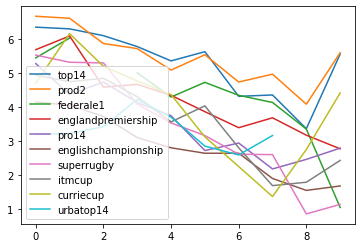

In [185]:
#print(leagues_10yr_stats)
for key, value in leagues_10yr_stats.items():
    plt.plot(value['pen_avg'])
#plt.labels = leagues_10yr_stats.keys()
plt.legend(leagues_10yr_stats.keys())

In [174]:
print(type(np.nan))

<class 'float'>
